# Project : Low Light Image Enhancement

This project focuses on **enhancing images captured in low-light conditions** using a **deep learning-based approach**. The model is based on a **U-Net architecture** with additional enhancements, including:
- **Edge-enhancement preprocessing** (Laplacian & Gaussian filters)
- **Res FFT-ReLU Block** (to reduce noise)
- **Channel Attention Module** (to restore color & brightness)
- **Pixel Shuffler** (for efficient upsampling)

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from glob import glob
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
!pip install pytorch-msssim
from pytorch_msssim import ssim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Loading the LOL dataset in notebook**

In [ ]:
dataset_path = "/content/drive/MyDrive/colab/lol_dataset/"
train_low = sorted(glob(os.path.join(dataset_path, "our485/low/*.png")))
train_high = sorted(glob(os.path.join(dataset_path, "our485/high/*.png")))
test_low = sorted(glob(os.path.join(dataset_path, "eval15/low/*.png")))
test_high = sorted(glob(os.path.join(dataset_path, "eval15/high/*.png")))

## **Create a Custom Dataset Loader**
- We combine low-light images with their corresponding edge maps to form 4-channel input (RGB + Edges).


In [ ]:
class LLIEPaperDataset(Dataset):
    def __init__(self, low_images, high_images, transform=None):
        self.low_images = low_images
        self.high_images = high_images
        self.transform = transform

    def preprocess_edges(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        blur = cv2.GaussianBlur(gray, (3, 3), 0)
        lap = cv2.Laplacian(blur, cv2.CV_64F)
        lap = (lap - lap.min()) / (lap.max() - lap.min() + 1e-8)  # Normalize 0-1
        lap = np.expand_dims(lap, axis=-1)
        return lap.astype(np.float32)

    def __getitem__(self, index):
        low = cv2.imread(self.low_images[index])
        high = cv2.imread(self.high_images[index])
        low = cv2.cvtColor(low, cv2.COLOR_BGR2RGB)
        high = cv2.cvtColor(high, cv2.COLOR_BGR2RGB)
        edge = self.preprocess_edges(low)

        # 🛠 Resize low and edge manually to SAME SIZE
        low = cv2.resize(low, (256, 256))
        edge = cv2.resize(edge, (256, 256))

        # 🛠 Now apply transforms separately
        rgb_tensor = transforms.ToTensor()(low)
        edge_tensor = transforms.ToTensor()(edge)

        low_tensor = torch.cat((rgb_tensor, edge_tensor), dim=0)
        high_tensor = transforms.ToTensor()(cv2.resize(high, (256, 256)))

        return low_tensor, high_tensor

    def __len__(self):
        return len(self.low_images)

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = LLIEPaperDataset(train_low, train_high, transform)
test_dataset = LLIEPaperDataset(test_low, test_high, transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


## **Build U-Net architecture**

- Here’s a U-Net model with attention and pixel shuffler for faster upsampling


In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()

        self.enc1 = nn.Sequential(
            nn.Conv2d(4, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.final = nn.Conv2d(64, 3, 1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.output_act(self.final(d1))

model = SimpleUNet().cuda()


## **Calculate SSIM Score**

In [ ]:
class SSIM_MSE_Loss(nn.Module):
    def __init__(self, alpha=0.84):
        super(SSIM_MSE_Loss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, pred, target):
        ssim_loss = 1 - ssim(pred, target, data_range=1.0, size_average=True)
        mse_loss = self.mse(pred, target)
        return self.alpha * ssim_loss + (1 - self.alpha) * mse_loss

criterion = SSIM_MSE_Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
import math

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    pixel_max = 1.0  # Since images are normalized
    psnr = 20 * math.log10(pixel_max / math.sqrt(mse))
    return psnr

## **Train Model**

In [ ]:
best_ssim = 0
ssim_scores = []

def evaluate(model, test_loader, epoch):
    global best_ssim
    model.eval()
    total_ssim = 0
    total_psnr = 0
    with torch.no_grad():
        for low, high in test_loader:
            low, high = low.cuda(), high.cuda()
            pred = model(low)

            pred_np = pred.squeeze().permute(1,2,0).cpu().numpy()
            high_np = high.squeeze().permute(1,2,0).cpu().numpy()

            # 🧠 Calculate SSIM and PSNR both
            ssim_val = compare_ssim(pred_np, high_np, win_size=7, channel_axis=-1, data_range=1.0)
            psnr_val = calculate_psnr(pred_np, high_np)

            total_ssim += ssim_val
            total_psnr += psnr_val

    avg_ssim = total_ssim / len(test_loader)
    avg_psnr = total_psnr / len(test_loader)
    ssim_scores.append(avg_ssim)

    print(f"✅ Epoch {epoch+1}: SSIM = {avg_ssim:.4f} | PSNR = {avg_psnr:.2f} dB")

    if avg_ssim > best_ssim:
        best_ssim = avg_ssim
        torch.save(model.state_dict(), "/content/drive/My Drive/colab/DL Project/best_paper_Unet_model.pth")
        print("💾 Best model saved")

# Train
N_epoch = 120
for epoch in range(N_epoch):
    model.train()
    total_loss = 0
    for low, high in train_loader:
        low, high = low.cuda(), high.cuda()
        pred = model(low)
        loss = criterion(pred, high)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"📚 Epoch [{epoch+1}/{N_epoch}], Loss: {total_loss/len(train_loader):.4f}")
    evaluate(model, test_loader, epoch)


📚 Epoch [1/120], Loss: 0.3540
✅ Epoch 1: SSIM = 0.6661 | PSNR = 16.44 dB
💾 Best model saved
📚 Epoch [2/120], Loss: 0.2362
✅ Epoch 2: SSIM = 0.7070 | PSNR = 17.33 dB
💾 Best model saved
📚 Epoch [3/120], Loss: 0.2126
✅ Epoch 3: SSIM = 0.7279 | PSNR = 17.57 dB
💾 Best model saved
📚 Epoch [4/120], Loss: 0.2013
✅ Epoch 4: SSIM = 0.7400 | PSNR = 17.87 dB
💾 Best model saved
📚 Epoch [5/120], Loss: 0.1922
✅ Epoch 5: SSIM = 0.7473 | PSNR = 17.90 dB
💾 Best model saved
📚 Epoch [6/120], Loss: 0.1857
✅ Epoch 6: SSIM = 0.7510 | PSNR = 17.62 dB
💾 Best model saved
📚 Epoch [7/120], Loss: 0.1825
✅ Epoch 7: SSIM = 0.7547 | PSNR = 17.70 dB
💾 Best model saved
📚 Epoch [8/120], Loss: 0.1782
✅ Epoch 8: SSIM = 0.7511 | PSNR = 17.42 dB
📚 Epoch [9/120], Loss: 0.1771
✅ Epoch 9: SSIM = 0.7481 | PSNR = 16.41 dB
📚 Epoch [10/120], Loss: 0.1754
✅ Epoch 10: SSIM = 0.7616 | PSNR = 17.67 dB
💾 Best model saved
📚 Epoch [11/120], Loss: 0.1743
✅ Epoch 11: SSIM = 0.7616 | PSNR = 17.21 dB
📚 Epoch [12/120], Loss: 0.1739
✅ Epoch 12

## **Plot SSIM Score per Epochs**

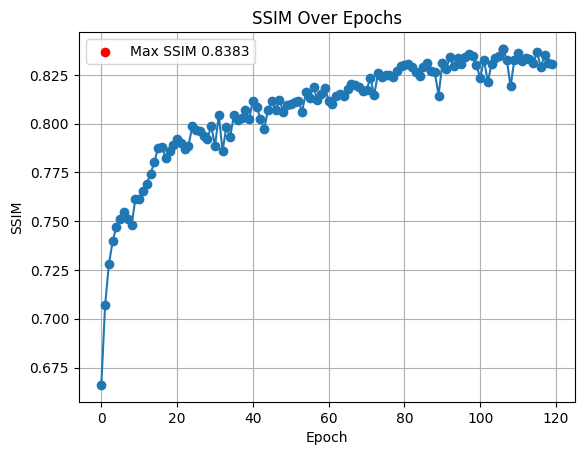


🔥 Highest SSIM achieved: 0.8383 at epoch 107


In [ ]:
plt.plot(ssim_scores, marker='o')
plt.title("SSIM Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("SSIM")
plt.grid(True)

max_ssim = max(ssim_scores)
max_epoch = np.argmax(ssim_scores)
plt.scatter(max_epoch, max_ssim, color='red', label=f'Max SSIM {max_ssim:.4f}')
plt.legend()

plt.show()

print(f"\n🔥 Highest SSIM achieved: {max_ssim:.4f} at epoch {max_epoch + 1}")


## **Result Phase**

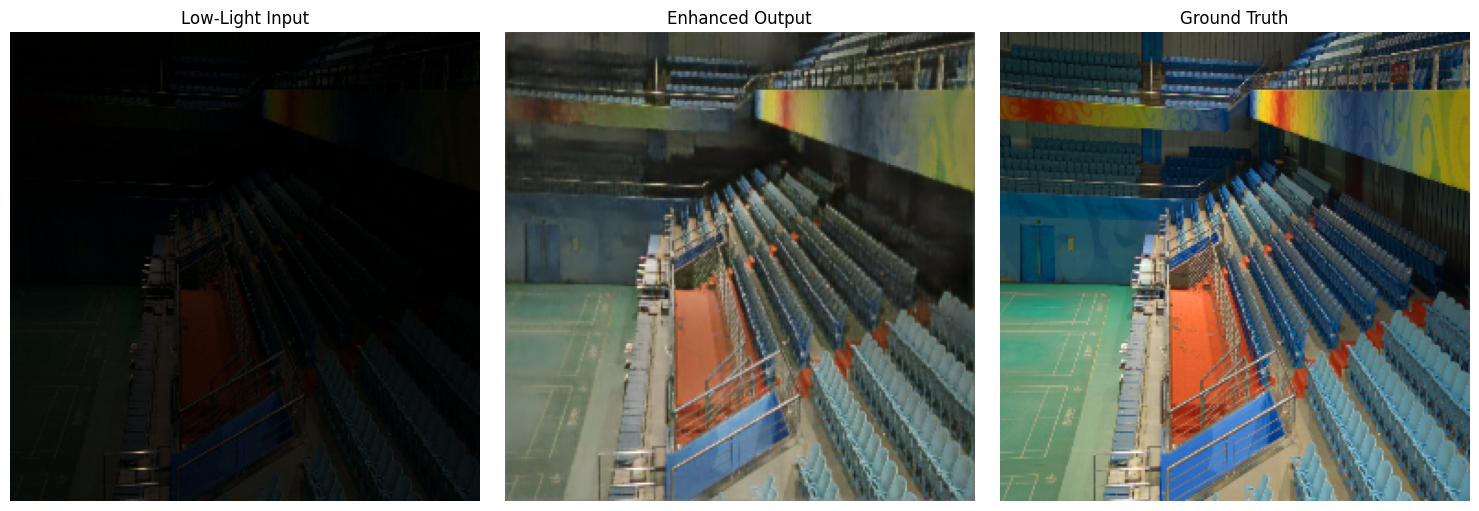

In [ ]:
def visualize_sample(index=0):
    model.eval()
    low, high = test_dataset[index]
    with torch.no_grad():
        pred = model(low.unsqueeze(0).cuda()).squeeze().permute(1, 2, 0).cpu().numpy()
    rgb = low[:3].permute(1, 2, 0).cpu().numpy()
    gt = high.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(np.clip(rgb, 0, 1)); ax[0].set_title("Low-Light Input"); ax[0].axis("off")
    ax[1].imshow(np.clip(pred, 0, 1)); ax[1].set_title("Enhanced Output"); ax[1].axis("off")
    ax[2].imshow(np.clip(gt, 0, 1)); ax[2].set_title("Ground Truth"); ax[2].axis("off")
    plt.tight_layout()
    plt.show()

# Example:
visualize_sample(index=12)


## **Test your custom input image**

**Enhance Uploaded Image**

In [ ]:
def preprocess_custom_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0)
    lap = cv2.Laplacian(blur, cv2.CV_64F)
    lap = (lap - lap.min()) / (lap.max() - lap.min() + 1e-8)
    lap = np.expand_dims(lap, axis=-1)

    img_rgb_resized = cv2.resize(img_rgb, (256, 256))
    lap_resized = cv2.resize(lap, (256, 256))

    rgb_tensor = transforms.ToTensor()(img_rgb_resized)
    lap_tensor = transforms.ToTensor()(lap_resized)

    input_tensor = torch.cat((rgb_tensor, lap_tensor), dim=0).unsqueeze(0).cuda().float()
    return img_rgb_resized, input_tensor

def enhance_uploaded_image(filename):
    original_rgb, input_tensor = preprocess_custom_image(filename)
    model.eval()
    with torch.no_grad():
        enhanced = model(input_tensor).squeeze().permute(1,2,0).cpu().numpy()

    # Display input and output
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.clip(original_rgb/255.0, 0, 1))
    plt.title("Low-Light Input")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(np.clip(enhanced, 0, 1))
    plt.title("Enhanced Output")
    plt.axis("off")
    plt.show()


Saving 2015_03042.jpg to 2015_03042.jpg
Saving 2015_03043.jpg to 2015_03043.jpg
Saving 2015_03044.jpg to 2015_03044.jpg
Saving 2015_03045.png to 2015_03045.png
Saving 2015_03046.png to 2015_03046.png
Saving 2015_03047.png to 2015_03047.png
Saving 2015_03048.jpg to 2015_03048.jpg
Saving 2015_03049.jpg to 2015_03049.jpg
✅ Uploaded File: ['2015_03042.jpg', '2015_03043.jpg', '2015_03044.jpg', '2015_03045.png', '2015_03046.png', '2015_03047.png', '2015_03048.jpg', '2015_03049.jpg']
✨ Enhancing: 2015_03042.jpg


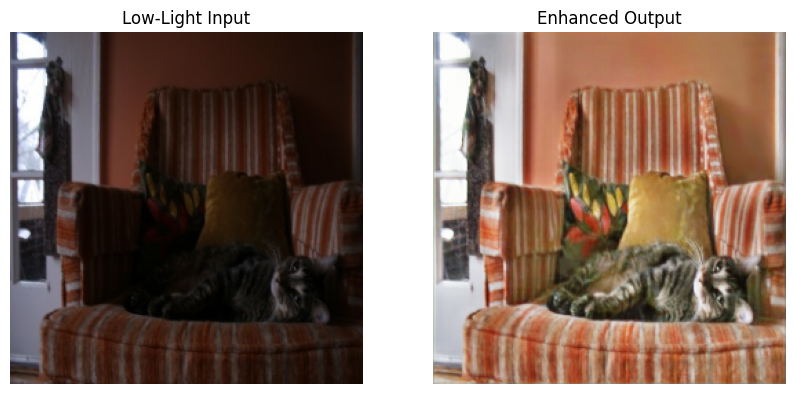

✨ Enhancing: 2015_03043.jpg


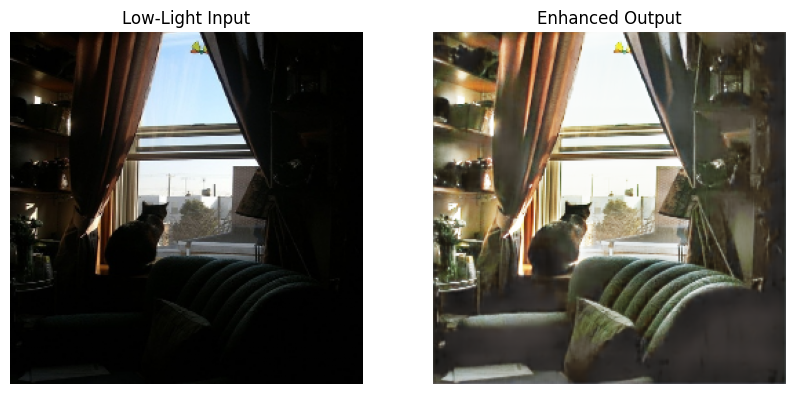

✨ Enhancing: 2015_03044.jpg


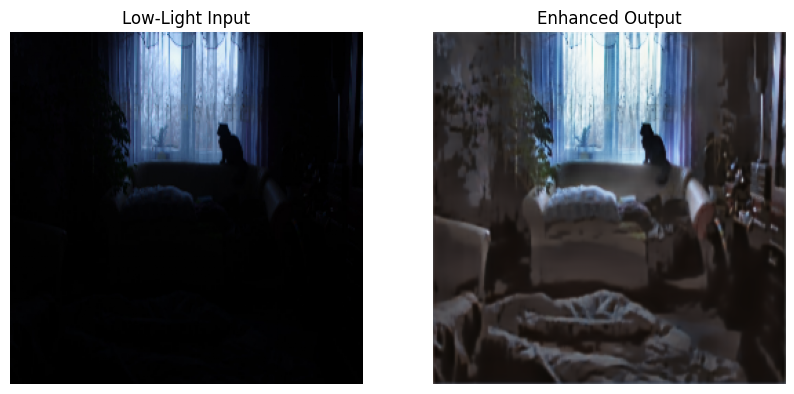

✨ Enhancing: 2015_03045.png


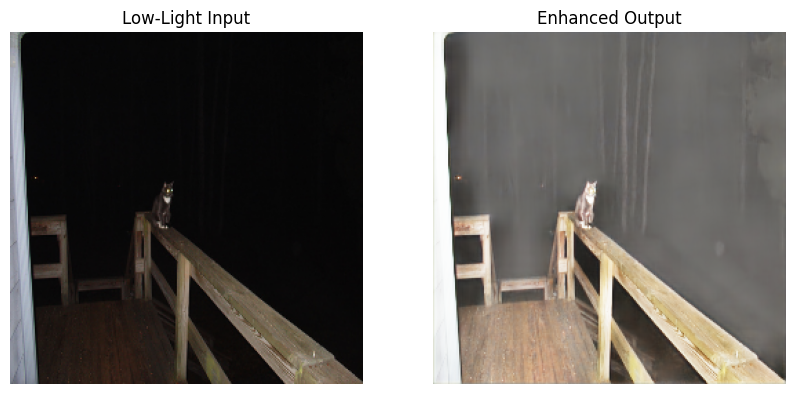

✨ Enhancing: 2015_03046.png


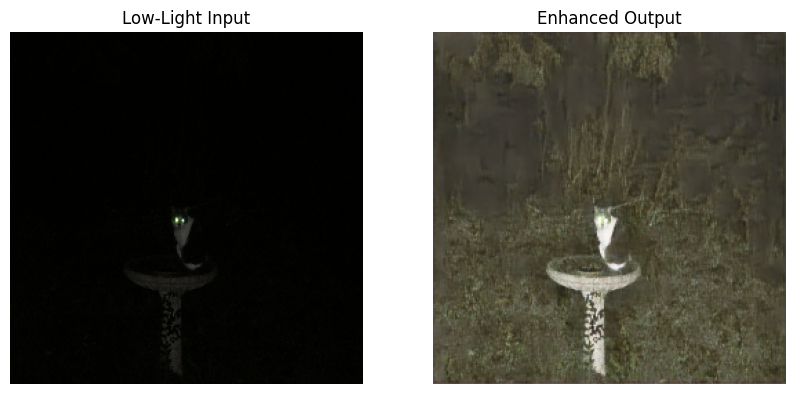

✨ Enhancing: 2015_03047.png


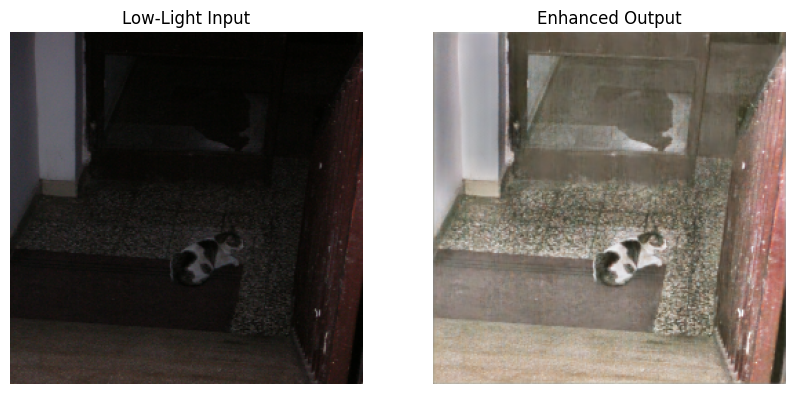

✨ Enhancing: 2015_03048.jpg


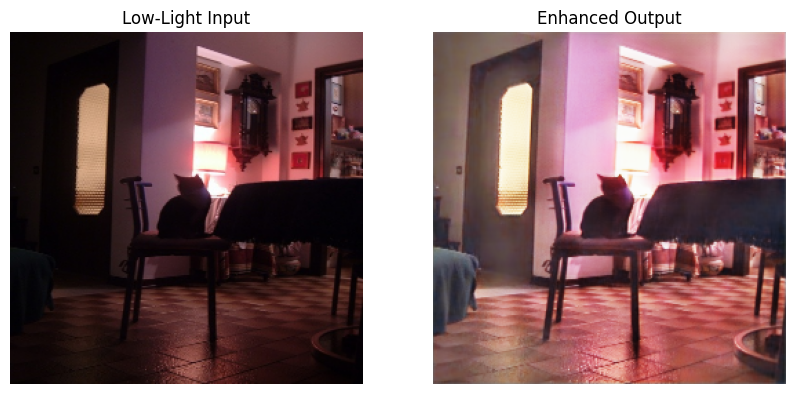

✨ Enhancing: 2015_03049.jpg


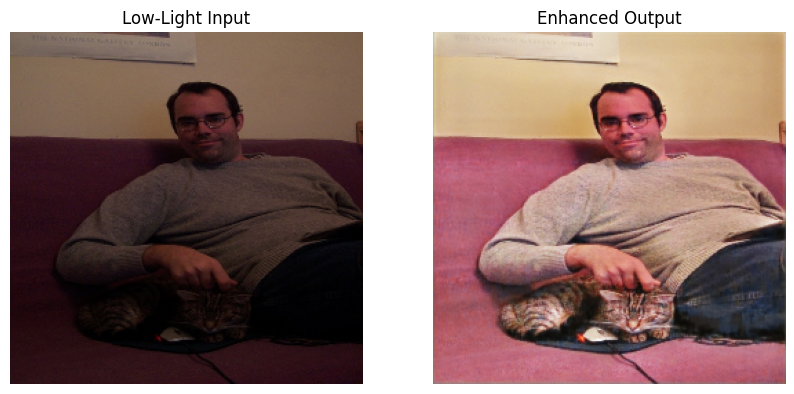

In [ ]:
from google.colab import files

uploaded = files.upload()  # 📂 Opens file picker
file_list = list(uploaded.keys())  # Gets uploaded filename
print(f"✅ Uploaded File: {file_list}")

for filename in file_list:
    print(f"✨ Enhancing: {filename}")
    enhance_uploaded_image(filename)